# Introduction

This notebook is to experiment with the basic GAN from the first [GAN paper](https://arxiv.org/abs/1406.2661).

THe main idea was to estimate the generative models via adverserial process. It was to pit generative model(G) against the disriminative model(D) to improve each other. In the case where G and D are defined by multilayer perceptrons, the entire system can be trained with backpropagation.

The paper doesn't showcase any state of the art results but just introduces a novel framework which might be very intersting moving forward.

# Code

In [1]:
from importlib import reload
import utils
reload(utils)

<module 'utils' from '/home/manoj/Documents/github/GAN/utils.py'>

In [2]:
import torch, torchvision
import torch.utils as tUtils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
# Loading the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]);

trainset = datasets.MNIST(root='./data', train=True,
                            download=True, transform=transform
                        );
trainloader = tUtils.data.DataLoader(trainset, batch_size=4,
                                        shuffle=True, num_workers=4)

testset = datasets.MNIST(root='./data', train=True,
                            download=True, transform=transform
                        );

testloader = tUtils.data.DataLoader(testset, batch_size=4,
                                        shuffle=True, num_workers=4)

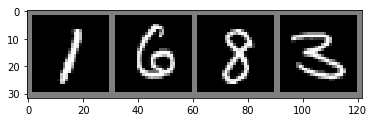

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [5]:
x = images[0].view(-1,784)

In [6]:
x.shape

torch.Size([1, 784])

In [7]:
type(images)

torch.FloatTensor

In [8]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [105]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class GAN_D(nn.Module):
    def __init__(self):
        super(GAN_D, self).__init__()
        self.fc1 = nn.Linear(784,300)
        self.fc2 = nn.Linear(300,300)
        self.fc3 = nn.Linear(300,1)        

    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

class GAN_G(nn.Module):
    def __init__(self):
        super(GAN_G, self).__init__()
        self.fc1 = nn.Linear(100,300)
        self.fc2 = nn.Linear(300,300)
        self.fc3 = nn.Linear(300,784) 


    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

In [106]:
# D = GAN_D().cuda()
# G = GAN_G().cuda()
D = GAN_D()
G = GAN_G()

In [97]:
images.view(-1,784)


-1.0000 -1.0000 -1.0000  ...  -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000  ...  -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000  ...  -1.0000 -1.0000 -1.0000
-1.0000 -1.0000 -1.0000  ...  -1.0000 -1.0000 -1.0000
[torch.FloatTensor of size 4x784]

In [67]:
D.parameters

<bound method Module.parameters of GAN_D (
  (fc1): Linear (784 -> 300)
  (fc2): Linear (300 -> 300)
  (fc3): Linear (300 -> 1)
)>

In [87]:
G.size()

AttributeError: 'GAN_G' object has no attribute 'size'

In [35]:
type(trainloader)

torch.utils.data.dataloader.DataLoader

In [98]:
x = Variable(images.view(-1,784))

In [100]:
out = D.forward(x)

In [101]:
from visualize import make_dot

In [102]:
make_dot(out)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

In [107]:
import torch.optim as optim

In [108]:
opt_D = optim.RMSprop(D.parameters(), lr = 1e-4)
opt_G = optim.RMSprop(G.parameters(), lr = 1e-4)

In [ ]:
def weights_init(m):
    m.weigh
    

In [109]:
criterion = nn.BCELoss()

In [110]:
def train_D(discriminator, images, real_labels, fake_images, fake_labels):
    discriminator.zero_grad()
    outputs = discriminator(images)
    real_loss = criterion(outputs, real_labels)
    real_score = outputs
    
    outputs = discriminator(fake_images)
    fake_loss = criterion(outputs, fake_labels)
    fake_score = outputs
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    opt_D.step()
    return d_loss, real_score, fake_score    

In [111]:
def train_G(generator, discriminator_outputs, real_labels):
    generator.zero_grad()
    gen_loss = criterion(discriminator_outputs, real_labels)
    gen_loss.backward()
    opt_G.step()
    return gen_loss    

In [112]:
def get_noise(shape, size):
    return torch.randn(shape, size)

In [113]:
def train(epochs, dataloader):
    for epoch in range(epochs):
        for n, (images, _) in enumerate(dataloader): #Look up for the output od dataloader
            images = Variable(images.view(-1,784))
            real_labels = Variable(torch.ones(images.size(0)))
            
            #Get input from generator
            noise = get_noise(images.size(0), 100)
            fake_images = G(Variable(noise))
            fake_labels = Variable(torch.zeros(images.size(0)))
            
            # Train the discriminator
            train_D(D, images, real_labels, fake_images, fake_labels)
            
            # Get some samples from generator
            noise = get_noise(images.size(0), 100)
            fake_images = G(Variable(noise))
            outputs = D(fake_images)
                
            # Train the generator
            train_G(G, outputs, real_labels)

In [129]:
train(10,trainloader)

/home/manoj/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


In [130]:
gan_out = G(Variable(get_noise(10, 100)))

In [131]:
gan_out= gan_out.data.numpy()

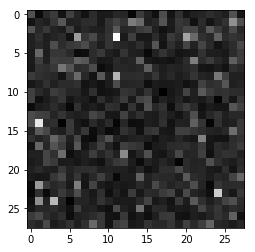

In [141]:
plt.imshow(gan_out.reshape(-1,28,28)[9,:,:], cmap="gray")

In [ ]:
D = GAN_D

In [ ]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class GAN_D(nn.Module):
    def __init__(self):
        super(GAN_D, self).__init__()
        self.conv1 = nn.Conv2d(3,8,5)
        self.conv2 = nn.Conv2d(8,16,5)
        self.conv3 = nn.Conv2d(16,1,3)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x

class GAN_G(nn.Module):
    def __init__(self):
        super(GAN_G, self).__init__()
        self.conv1 = nn.Conv2d(1,8,5)
        self.conv2 = nn.Conv2d(8,16,5)
        self.conv3 = nn.Conv2d(16,1,3)


    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return x
